# Single Photon Detection Analysis

The following code contains functions to plot single, two, and multi photon data plots from the .h5 files. 


It also contains functions to create histograms the max amplitude count for each different peak in the graph.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import math
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import poisson
import pandas as pd

### Photon_count_analysis calculates the max amplitude of the first peak of the graph

In [3]:
def Photon_count_analysis(your_file_path, Number_of_files):
    
    NumFiles = Number_of_files
    amplitudeData = []
    
    for i in range(NumFiles):
        
        
        
        with h5py.File(f'{your_file_path}/g2_PNR2binary_EDFA2_850mA_10.0uA_{i+1}of3.h5', 'r') as h5_file:
            WaveformAttrId1 = h5_file['Waveforms/Channel 1']
            WaveformAttrId3 = h5_file['Waveforms/Channel 3']
            y_inc_0 = WaveformAttrId1.attrs.get('YInc')
            y_org_0 = WaveformAttrId1.attrs.get('YOrg')
            y_inc_3 = WaveformAttrId3.attrs.get('YInc')
            y_org_3 = WaveformAttrId3.attrs.get('YOrg')
            numSegments = WaveformAttrId3.attrs.get('NumSegments')
            numSegments = int(numSegments)
            maxSum = np.zeros(numSegments)
            
            member_names_channel3 = []
            member_names_channel1 = []
            
            
            
            for member_name in WaveformAttrId3.keys():
                
                member_names_channel3.append(member_name)
                
            for member_name in WaveformAttrId1.keys():
                
                member_names_channel1.append(member_name)
                
            

            for i in range(len(member_names_channel3)):
                
                channel3_path = f'Waveforms/Channel 3/{member_names_channel3[i]}'
                channel1_path = f'Waveforms/Channel 1/{member_names_channel1[i]}'
                channel_data = h5_file[channel3_path][:]
                channel_data1 = h5_file[channel1_path][:]
                
                y_Data_channel1 = channel_data1 * y_inc_0 + y_org_0
                y_Data_channel3 = channel_data * y_inc_3 + y_org_3
                pulseSum = y_Data_channel3 - y_Data_channel1
                maxSum[i] = np.max(pulseSum)
    

        amplitudeData.extend(maxSum)
        

    for i in range(len(amplitudeData)):
        amplitudeData[i] = amplitudeData[i] * 1000
        
    print(f"The first 20 values of are: {amplitudeData[:20]}")  
    print(f'The size of the list is: {len(amplitudeData)}')
    
    return amplitudeData 
    

The first 20 values of are: [np.float64(49.868498780534345), np.float64(50.2033231320117), np.float64(49.84010865796186), np.float64(48.69014502339457), np.float64(50.25181742328343), np.float64(50.2331782062653), np.float64(50.399750116481734), np.float64(48.26026329317752), np.float64(49.25276475725483), np.float64(49.21394375506273), np.float64(57.144496453818476), np.float64(49.73888286401948), np.float64(51.382582282958005), np.float64(49.27459411413526), np.float64(56.55723416106477), np.float64(49.17998358339951), np.float64(49.98308721487933), np.float64(48.530370996410106), np.float64(50.879826073133685), np.float64(49.57707662115925)]
The size of the list is: 98304


<function matplotlib.pyplot.show(close=None, block=None)>

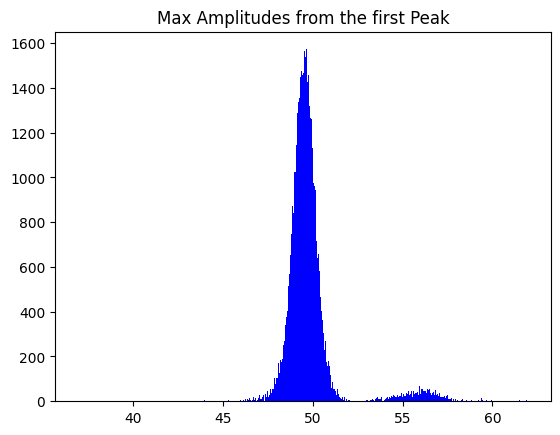

In [32]:
Data = Photon_count_analysis('/Users/gabriel/Code/Single Photon Detection/20.53.57_EDFA2_850mA', 3)


plt.hist(Data, bins=1000, color='blue')
plt.title('Max Amplitudes from the first Peak')
plt.show

### Sorting_photon_count Sorts the different data files belonging to the different max amplitudes from the above histogram by estimating a threshold, here it's 52.5 mV

In [4]:
def Sorting_photon_count(Your_Data):
    Single_Photon_Count = 0
    Multi_Photon_Count = 0
    
    
    for i in range (len(Your_Data)):
        
        if Your_Data[i] < 52.5:
            Single_Photon_Count = Single_Photon_Count + 1
        else:
            Multi_Photon_Count = Multi_Photon_Count + 1
            
            
    
    
    return Single_Photon_Count, Multi_Photon_Count

In [22]:
Data = Photon_count_analysis('/Users/gabriel/Code/Single Photon Detection/20.53.57_EDFA2_850mA', 3)

Single_Photons, Multi_Photons = Sorting_photon_count(Data)

print(f"Single Photon Count = {Single_Photons}")
print(f"Multi Photon Count = {Multi_Photons}")
print(f"Total = {Single_Photons+Multi_Photons}")

The first 20 values of are: [np.float64(49.868498780534345), np.float64(50.2033231320117), np.float64(49.84010865796186), np.float64(48.69014502339457), np.float64(50.25181742328343), np.float64(50.2331782062653), np.float64(50.399750116481734), np.float64(48.26026329317752), np.float64(49.25276475725483), np.float64(49.21394375506273), np.float64(57.144496453818476), np.float64(49.73888286401948), np.float64(51.382582282958005), np.float64(49.27459411413526), np.float64(56.55723416106477), np.float64(49.17998358339951), np.float64(49.98308721487933), np.float64(48.530370996410106), np.float64(50.879826073133685), np.float64(49.57707662115925)]
The size of the list is: 98304
Single Photon Count = 93312
Multi Photon Count = 4992
Total = 98304


### Sorting_Single_Multi_Photon sorts the different data file inside Channel 3 into two list of "Single_Photon_Files" and "Multi_Photon_Files

In [5]:
def Sorting_Single_Multi_Photon(your_file_path, File_number):
    
    File_num = File_number
    
    Single_Photon_Files = []
    Multi_Photon_Files = []
    
    
    
    for i in range(File_num):
        
        with h5py.File(f'{your_file_path}/g2_PNR2binary_EDFA2_850mA_10.0uA_{i+1}of3.h5', 'r') as h5_file:
            
            WaveformAttrId1 = h5_file['Waveforms/Channel 1']
            WaveformAttrId3 = h5_file['Waveforms/Channel 3']
            y_inc_0 = WaveformAttrId1.attrs.get('YInc')
            y_org_0 = WaveformAttrId1.attrs.get('YOrg')
            y_inc_3 = WaveformAttrId3.attrs.get('YInc')
            y_org_3 = WaveformAttrId3.attrs.get('YOrg')
            numSegments = WaveformAttrId3.attrs.get('NumSegments')
            numSegments = int(numSegments)
            maxSum = np.zeros(numSegments)
            
            member_names_channel_1 = list(WaveformAttrId1.keys())
            member_names_channel_3 = list(WaveformAttrId3.keys())
            
            
            for i in range(len(member_names_channel_3)):
                    
                channel3_path = f'Waveforms/Channel 3/{member_names_channel_3[i]}'
                channel1_path = f'Waveforms/Channel 1/{member_names_channel_1[i]}'
                
                
                channel_data3 = h5_file[channel3_path][:]
                channel_data1 = h5_file[channel1_path][:]
                
                y_Data_channel1 = channel_data1 * y_inc_0 + y_org_0
                y_Data_channel3 = channel_data3 * y_inc_3 + y_org_3
                
                pulseSum = y_Data_channel3 - y_Data_channel1
                
                if np.max(pulseSum) < 0.052:
                    Single_Photon_Files.append(member_names_channel_3[i])
                    
                else:
                    Multi_Photon_Files.append(member_names_channel_3[i])
                
    return Single_Photon_Files, Multi_Photon_Files

In [ ]:
Single, Multi = Sorting_Single_Multi_Photon('/Users/gabriel/Code/Single Photon Detection/20.53.57_EDFA2_850mA', 3)

print(len(Single))
print(len(Multi))

print(Single[:10])
print(Multi[:10])

print(len(Single)+len(Multi))

value_single = len(Single)*0.90
print(value_single)

value_multi = len(Multi)*0.90
print(value_multi)

for i in range(int(value_single)):
    x = np.random.randint(len(Single))
    Single.remove(Single[x])
    
    
for i in range(int(value_multi)):
    x = np.random.randint(len(Multi))
    Multi.remove(Multi[x])
            
        



print(len(Single))
print(len(Multi))


93276
5028
['Channel 3 Seg10000Data', 'Channel 3 Seg10001Data', 'Channel 3 Seg10002Data', 'Channel 3 Seg10003Data', 'Channel 3 Seg10004Data', 'Channel 3 Seg10005Data', 'Channel 3 Seg10006Data', 'Channel 3 Seg10007Data', 'Channel 3 Seg10008Data', 'Channel 3 Seg10009Data']
['Channel 3 Seg1000Data', 'Channel 3 Seg10013Data', 'Channel 3 Seg10028Data', 'Channel 3 Seg10065Data', 'Channel 3 Seg10105Data', 'Channel 3 Seg10136Data', 'Channel 3 Seg10166Data', 'Channel 3 Seg10187Data', 'Channel 3 Seg101Data', 'Channel 3 Seg10202Data']
98304
83948.40000000001
4525.2
9328
503


### The following code plots the graph while seperating the Single Photon Files and the Multi Photon Files seen previously in two different colors, blue for single and red for multi

92343.24
4977.72


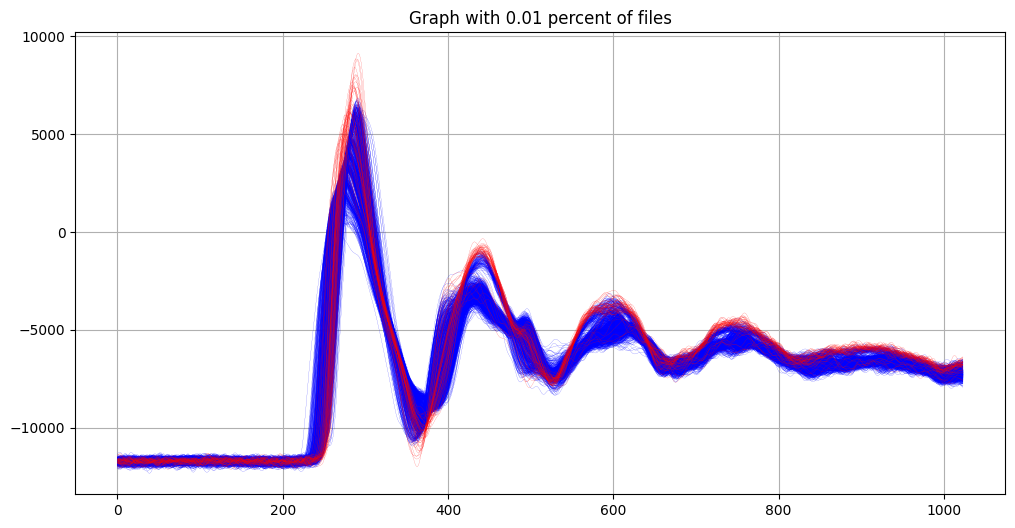

In [9]:
your_file_path = '/Users/gabriel/Code/Single Photon Detection/20.53.57_EDFA2_850mA'
    
Single_Photon_Files, Multi_Photon_Files = Sorting_Single_Multi_Photon(your_file_path, 3)


value_single = len(Single_Photon_Files)*0.99
print(value_single)

value_multi = len(Multi_Photon_Files)*0.99
print(value_multi)

for i in range(int(value_single)):
    x = np.random.randint(len(Single_Photon_Files))
    Single_Photon_Files.remove(Single_Photon_Files[x])
    
    
for i in range(int(value_multi)):
    x = np.random.randint(len(Multi_Photon_Files))
    Multi_Photon_Files.remove(Multi_Photon_Files[x])

    

plt.figure(figsize=(12, 6))






for file_name in Single_Photon_Files:
    with h5py.File(f'{your_file_path}/g2_PNR2binary_EDFA2_850mA_10.0uA_1of3.h5', 'r') as h5_file:
        
        
        raw_data = h5_file[f'Waveforms/Channel 3/{file_name}'][:]
        
        
        plt.plot(raw_data, linewidth=0.1, color='blue')


for file_name in Multi_Photon_Files:
    with h5py.File(f'{your_file_path}/g2_PNR2binary_EDFA2_850mA_10.0uA_1of3.h5', 'r') as h5_file:
        
        
    
        raw_data = h5_file[f'Waveforms/Channel 3/{file_name}'][:]
        
            
        plt.plot(raw_data,linewidth=0.1,  color='red')





plt.grid(True)
plt.title('Graph with 0.01 percent of files')
plt.show()
    
    
    


### Ideas to incorperate

Devide plot into 5 different subplots of all the different peaks. Then run each perak into the python code to find the max amplitude, and plo the histograms. Get the number of events, and compare with previous results

### Photon_count_analysis_with_Delimetations plots stores the max amplitude for any given peak. If you want to know the max amplitudes of the second peak, you estimate after which data it is found.

To get the second peak, next_peak = 380

For the third peak, next_peak = 550

For the fourth peak, next_peak = 680

For the fift peak, next_peak = 810

In [10]:
def Photon_count_analysis_with_delimetations(your_file_path, Number_of_files, next_peak):
    
    starting = next_peak
    NumFiles = Number_of_files
    amplitudeData = []
    
    for i in range(NumFiles):
        
        
        
        with h5py.File(f'{your_file_path}/g2_PNR2binary_EDFA2_850mA_10.0uA_{i+1}of3.h5', 'r') as h5_file:
            WaveformAttrId1 = h5_file['Waveforms/Channel 1']
            WaveformAttrId3 = h5_file['Waveforms/Channel 3']
            y_inc_0 = WaveformAttrId1.attrs.get('YInc')
            y_org_0 = WaveformAttrId1.attrs.get('YOrg')
            y_inc_3 = WaveformAttrId3.attrs.get('YInc')
            y_org_3 = WaveformAttrId3.attrs.get('YOrg')
            numSegments = WaveformAttrId3.attrs.get('NumSegments')
            numSegments = int(numSegments)
            maxSum = np.zeros(numSegments)
            
            member_names_channel3 = []
            member_names_channel1 = []
            
            
            
            for member_name in WaveformAttrId3.keys():
                
                member_names_channel3.append(member_name)
                
            for member_name in WaveformAttrId1.keys():
                
                member_names_channel1.append(member_name)
                
            

            for i in range(len(member_names_channel3)):
                
                channel3_path = f'Waveforms/Channel 3/{member_names_channel3[i]}'
                channel1_path = f'Waveforms/Channel 1/{member_names_channel1[i]}'
                channel_data = h5_file[channel3_path][starting:]
                channel_data1 = h5_file[channel1_path][starting:]
                
                y_Data_channel1 = channel_data1 * y_inc_0 + y_org_0
                y_Data_channel3 = channel_data * y_inc_3 + y_org_3
                pulseSum = y_Data_channel3 - y_Data_channel1
                maxSum[i] = np.max(pulseSum)
    

        amplitudeData.extend(maxSum)
        

    for i in range(len(amplitudeData)):
        amplitudeData[i] = amplitudeData[i] * 1000
        
    print(f"The first 20 values of are: {amplitudeData[:20]}")  
    print(f'The size of the list is: {len(amplitudeData)}')
    
    return amplitudeData 
    

The first 20 values of are: [np.float64(27.55850073428407), np.float64(25.585680984368974), np.float64(27.20917336511553), np.float64(28.071151661450703), np.float64(26.267213820825802), np.float64(28.380696279685285), np.float64(27.242661435756798), np.float64(28.608056511862877), np.float64(28.099736101847135), np.float64(27.633080997953837), np.float64(34.647041342515266), np.float64(27.04881452723847), np.float64(25.1948204230673), np.float64(26.84311458713535), np.float64(34.473413169987545), np.float64(27.85171028567498), np.float64(26.052386594298273), np.float64(27.443615112622396), np.float64(26.257142332357493), np.float64(26.726157941360547)]
The size of the list is: 98304


<function matplotlib.pyplot.show(close=None, block=None)>

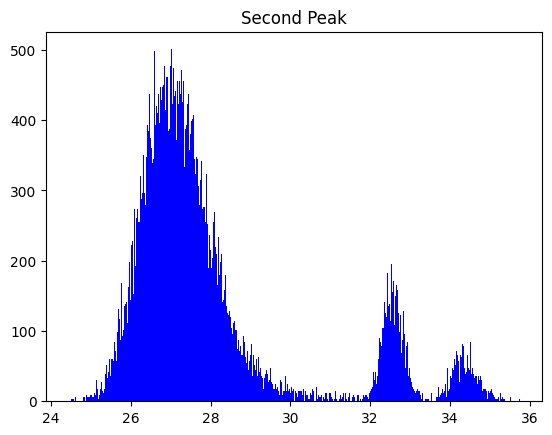

In [45]:
Data = Photon_count_analysis_with_delimetations('/Users/gabriel/Code/Single Photon Detection/20.53.57_EDFA2_850mA', 3, 380)


plt.hist(Data, bins=1000, color='blue')
plt.title('Second Peak')
plt.show

The first 20 values of are: [np.float64(22.39796722969918), np.float64(22.59514409838917), np.float64(22.462658624925954), np.float64(22.79572668630482), np.float64(22.587407862012622), np.float64(22.829636351932038), np.float64(23.231883692695877), np.float64(22.996837730177738), np.float64(22.84193623152079), np.float64(23.03714308816965), np.float64(26.882872085051307), np.float64(22.683018949727586), np.float64(22.658998152543358), np.float64(22.90757182879147), np.float64(26.40226767244209), np.float64(22.885911536716996), np.float64(22.205455016293396), np.float64(22.730324215095457), np.float64(22.80847341389752), np.float64(22.873510645056246)]
The size of the list is: 98304


<function matplotlib.pyplot.show(close=None, block=None)>

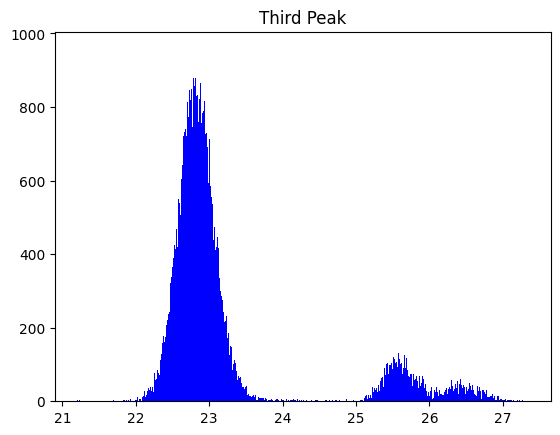

In [46]:
Data = Photon_count_analysis_with_delimetations('/Users/gabriel/Code/Single Photon Detection/20.53.57_EDFA2_850mA', 3, 550)


plt.hist(Data, bins=1000, color='blue')
plt.title('Third Peak')
plt.show

The first 20 values of are: [np.float64(20.347048787018025), np.float64(19.819372235102254), np.float64(20.06197181397162), np.float64(20.330556353167026), np.float64(19.57381378501117), np.float64(20.207645014132172), np.float64(19.863718629248414), np.float64(20.3202769916554), np.float64(20.15128822139389), np.float64(19.96368548713226), np.float64(23.294478810791528), np.float64(19.861830225160602), np.float64(19.754731345911477), np.float64(19.85454083678801), np.float64(23.08164684932313), np.float64(20.213939694424862), np.float64(19.634576853954332), np.float64(20.076027983658857), np.float64(19.708892889645462), np.float64(20.086200484199164)]
The size of the list is: 98304


<function matplotlib.pyplot.show(close=None, block=None)>

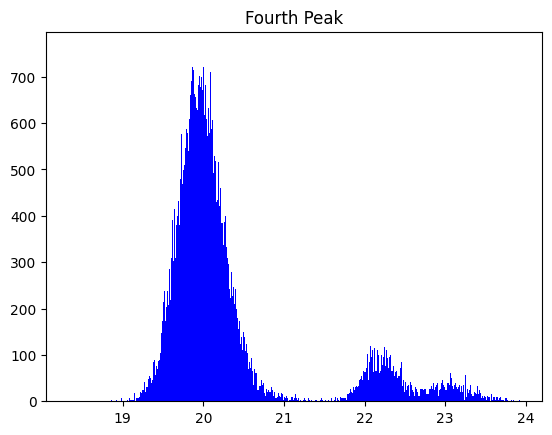

In [47]:
Data = Photon_count_analysis_with_delimetations('/Users/gabriel/Code/Single Photon Detection/20.53.57_EDFA2_850mA', 3, 680)


plt.hist(Data, bins=1000, color='blue')
plt.title('Fourth Peak')
plt.show

The first 20 values of are: [np.float64(16.90451718184343), np.float64(16.777331680593004), np.float64(16.682740553975943), np.float64(17.139771017404886), np.float64(16.843074138835), np.float64(16.94547726088261), np.float64(16.936928936451476), np.float64(17.288616810729778), np.float64(17.021605941607543), np.float64(17.069647535976006), np.float64(19.475055357149856), np.float64(17.15589821120525), np.float64(16.652191950437704), np.float64(16.961421834657656), np.float64(19.26098971264092), np.float64(17.029184810976776), np.float64(16.420633315098545), np.float64(16.937558404480747), np.float64(16.625363800139763), np.float64(16.637688932746514)]
The size of the list is: 98304


<function matplotlib.pyplot.show(close=None, block=None)>

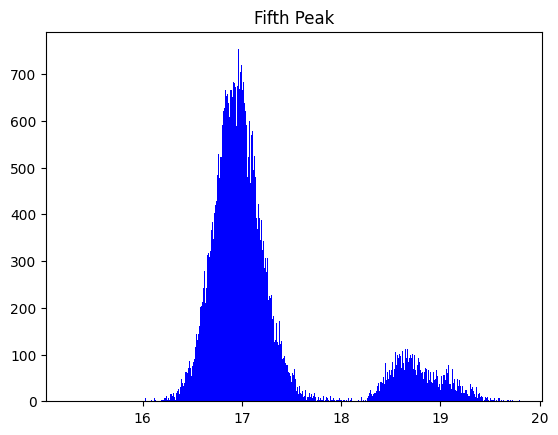

In [11]:
Data = Photon_count_analysis_with_delimetations('/Users/gabriel/Code/Single Photon Detection/20.53.57_EDFA2_850mA', 3, 810)


plt.hist(Data, bins=1000, color='blue')
plt.title('Fifth Peak')
plt.show

### Sorting_Single_Multi_Photon_Other_Peak sorts the different name of the files inside Channel 3 using the Second Peak Histogram analysis. 

In the second peak histogram, we can clearly see three different bunches. One for Single Photon, another for Two photons and one for Multi Photon ( I assume). 

The function calculates the different max amplitudes of the second peak and sorts them depending on approximate thresholds decided arbitrarely.

In [2]:
def Sorting_Single_Multi_Photon_Other_Peak(your_file_path):
    
    Single_Photon_Files = []
    Two_Photon_Files = []
    Multi_Photon_Files = []
    
    Single_Photon_Files_Channel_1 = []
    Two_Photon_Files_Channel_1 = []
    Multi_Photon_Files_Channel_1 = []
    
    
    
        
    with h5py.File(f'{your_file_path}/g2_PNR2binary_EDFA2_850mA_10.0uA_{1}of3.h5', 'r') as h5_file:
        
        WaveformAttrId1 = h5_file['Waveforms/Channel 1']
        WaveformAttrId3 = h5_file['Waveforms/Channel 3']
        y_inc_0 = WaveformAttrId1.attrs.get('YInc')
        y_org_0 = WaveformAttrId1.attrs.get('YOrg')
        y_inc_3 = WaveformAttrId3.attrs.get('YInc')
        y_org_3 = WaveformAttrId3.attrs.get('YOrg')
        numSegments = WaveformAttrId3.attrs.get('NumSegments')
        numSegments = int(numSegments)
        maxSum = np.zeros(numSegments)
        
        member_names_channel_1 = list(WaveformAttrId1.keys())
        member_names_channel_3 = list(WaveformAttrId3.keys())
        
        
        for i in range(len(member_names_channel_3)):
                
            channel3_path = f'Waveforms/Channel 3/{member_names_channel_3[i]}'
            channel1_path = f'Waveforms/Channel 1/{member_names_channel_1[i]}'
            
            
            channel_data3 = h5_file[channel3_path][380:]
            channel_data1 = h5_file[channel1_path][380:]
            
            y_Data_channel1 = channel_data1 * y_inc_0 + y_org_0
            y_Data_channel3 = channel_data3 * y_inc_3 + y_org_3
            
            pulseSum = y_Data_channel3 - y_Data_channel1
            
            if np.max(pulseSum) < 0.031:
                Single_Photon_Files.append(member_names_channel_3[i])
                Single_Photon_Files_Channel_1.append(member_names_channel_1[i])
                
            elif np.max(pulseSum) < 0.0335:
                Two_Photon_Files.append(member_names_channel_3[i])
                Two_Photon_Files_Channel_1.append(member_names_channel_1[i])
            else:
                Multi_Photon_Files.append(member_names_channel_3[i])
                Multi_Photon_Files_Channel_1.append(member_names_channel_1[i])
                
    return Single_Photon_Files, Two_Photon_Files, Multi_Photon_Files, Single_Photon_Files_Channel_1, Two_Photon_Files_Channel_1, Multi_Photon_Files_Channel_1

In [ ]:
Single, Two, Multi, Single_Photon_Files_Channel_1, Two_Photon_Files_Channel_1, Multi_Photon_Files_Channel_1 = Sorting_Single_Multi_Photon_Other_Peak('/Users/gabriel/Code/Single Photon Detection/20.53.57_EDFA2_850mA')
                                                     

print(len(Single))
print(len(Two))
print(len(Multi))

print(len(Single)+len(Multi)+len(Two)) 


print(Multi[:10])
      
print(Single_Photon_Files_Channel_1[:15])



28239
3113
1416
32768
['Channel 3 Seg1000Data', 'Channel 3 Seg10013Data', 'Channel 3 Seg10028Data', 'Channel 3 Seg10065Data', 'Channel 3 Seg10136Data', 'Channel 3 Seg10166Data', 'Channel 3 Seg10202Data', 'Channel 3 Seg10218Data', 'Channel 3 Seg10223Data', 'Channel 3 Seg10233Data']
['Channel 1 Seg10000Data', 'Channel 1 Seg10001Data', 'Channel 1 Seg10002Data', 'Channel 1 Seg10003Data', 'Channel 1 Seg10004Data', 'Channel 1 Seg10005Data', 'Channel 1 Seg10006Data', 'Channel 1 Seg10007Data', 'Channel 1 Seg10008Data', 'Channel 1 Seg10009Data', 'Channel 1 Seg10010Data', 'Channel 1 Seg10011Data', 'Channel 1 Seg10012Data', 'Channel 1 Seg10014Data', 'Channel 1 Seg10015Data']


26827.05
2957.35
1345.2


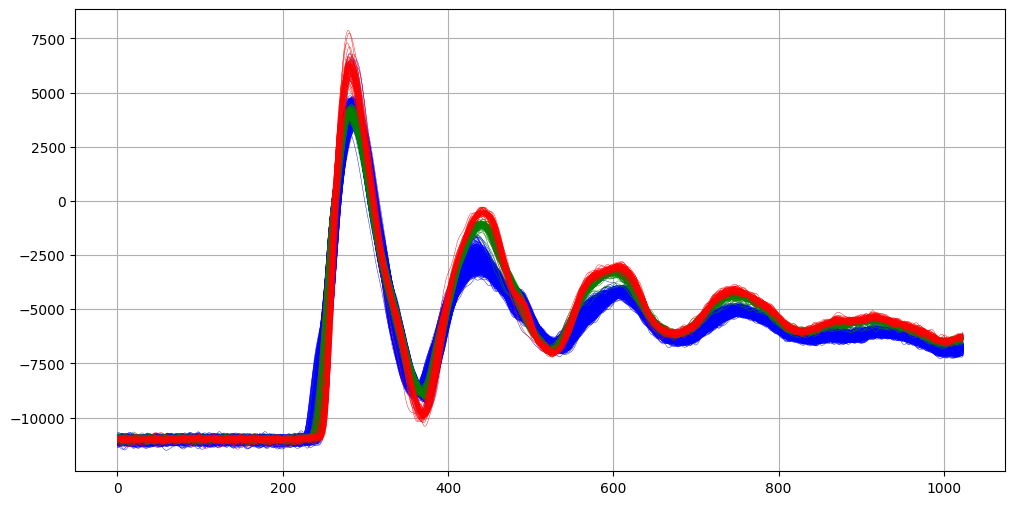

In [6]:
your_file_path = '/Users/gabriel/Code/Single Photon Detection/20.53.57_EDFA2_850mA'
    
Single_Photon_Files, Two_Photon_Files, Multi_Photon_Files, Single_Photon_Files_Channel_1, Two_Photon_Files_Channel_1, Multi_Photon_Files_Channel_1 = Sorting_Single_Multi_Photon_Other_Peak('/Users/gabriel/Code/Single Photon Detection/20.53.57_EDFA2_850mA')


value_single = len(Single_Photon_Files)*0.95
print(value_single)

value_two = len(Two_Photon_Files)*0.95
print(value_two)

value_multi = len(Multi_Photon_Files)*0.95
print(value_multi)

for i in range(int(value_single)):
    x = np.random.randint(len(Single_Photon_Files))
    Single_Photon_Files.remove(Single_Photon_Files[x])
    Single_Photon_Files_Channel_1.remove(Single_Photon_Files_Channel_1[x])


for i in range(int(value_multi)):
    x = np.random.randint(len(Multi_Photon_Files))
    Multi_Photon_Files.remove(Multi_Photon_Files[x])
    Multi_Photon_Files_Channel_1.remove(Multi_Photon_Files_Channel_1[x])

for i in range(int(value_two)):
    x = np.random.randint(len(Two_Photon_Files))
    Two_Photon_Files.remove(Two_Photon_Files[x])
    Two_Photon_Files_Channel_1.remove(Two_Photon_Files_Channel_1[x])


    

plt.figure(figsize=(12, 6))




with h5py.File(f'{your_file_path}/g2_PNR2binary_EDFA2_850mA_10.0uA_1of3.h5', 'r') as h5_file:
    

    for i in range(len(Single_Photon_Files)):
        
        
        
        raw_data_Pos = h5_file[f'Waveforms/Channel 3/{Single_Photon_Files[i]}'][:]
        raw_data_Neg = h5_file[f'Waveforms/Channel 1/{Single_Photon_Files_Channel_1[i]}'][:]
        raw_data = (raw_data_Pos - raw_data_Neg)/2
    
        plt.plot(raw_data, linewidth=0.3, color='blue')


    for i in range(len(Two_Photon_Files)):
       
            
        raw_data_Pos = h5_file[f'Waveforms/Channel 3/{Two_Photon_Files[i]}'][:]
        raw_data_Neg = h5_file[f'Waveforms/Channel 1/{Two_Photon_Files_Channel_1[i]}'][:]
        raw_data = (raw_data_Pos - raw_data_Neg)/2
        
        plt.plot(raw_data,linewidth=0.3,  color='green')


    for i in range(len(Multi_Photon_Files)):
        
        
        raw_data_Pos = h5_file[f'Waveforms/Channel 3/{Multi_Photon_Files[i]}'][:]
        raw_data_Neg = h5_file[f'Waveforms/Channel 1/{Multi_Photon_Files_Channel_1[i]}'][:]
        raw_data = (raw_data_Pos - raw_data_Neg)/2

            
        plt.plot(raw_data,linewidth=0.3,  color='red')





plt.grid(True)
plt.show()
    
    
    


In [29]:
Single, Multi = Sorting_Single_Multi_Photon('/Users/gabriel/Code/Single Photon Detection/20.53.57_EDFA2_850mA', 1)

Single_2, Two_2, Multi_2 = Sorting_Single_Multi_Photon_Other_Peak('/Users/gabriel/Code/Single Photon Detection/20.53.57_EDFA2_850mA')

count = 0

Total = len(Single) + len(Multi)
Total_2 = len(Single_2) + len(Two_2) + len(Multi_2)

All_Multi_2 = Two_2 + Multi_2

print(Total)
print(Total_2)


print(len(All_Multi_2))

print(len(Single_2)+len(All_Multi_2))

for i in range(len(Single_2)):
    
    if Single_2[i] in Single:
        count = count + 1

print(count/len(Single))
print(len(Single_2)/len(Single))


32768
32768
4529
32768
0.9001350829795446
0.9082400617522193


In [12]:
your_file_path = '/Users/gabriel/Code/Single Photon Detection/20.53.57_EDFA2_850mA'

Channel_1_names = ['Channel 1 Seg10000Data', 'Channel 1 Seg10001Data']


with h5py.File(f'{your_file_path}/g2_PNR2binary_EDFA2_850mA_10.0uA_1of3.h5', 'r') as h5_file:
    
    data = h5_file[f'Waveforms/Channel 1/{Channel_1_names[1]}'][:]
    print(data)

[10356 10372 10400 ...  6500  6492  6472]
